In [1]:
import terra_to_data as ttd
import materials_propellant as mp
import numpy as np
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#Perараметры текста
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
ttd.open_terra_df('Компот2.xlsx')

In [3]:
p0 = 10.8e6
omega = 100.22
t_r = 2.6

# propellant_name = '17% ПБКГ, 67% ПХА, 16% Al'
propellant_name = '25% ПБАК, 75% ПХА'
propellant = mp.get_mixed_propellant(propellant_name)
z = 0.281
rho_kf = 2700
cs = 920
ds = 6.5e-6
T0 = propellant['T_0']

km = ttd.to_data('kg')
Rm = ttd.to_data('Rg')
mu_m = ttd.to_data('Mu')
lambda_t_m = ttd.to_data('Lt')
cpm = ttd.to_data('Cpg')

k = lambda p,T: km(T,p / 1e6)[0]
R = lambda p,T: Rm(T,p / 1e6)[0]
mu = lambda p,T: mu_m(T,p / 1e6)[0]
lambda_t = lambda p,T: lambda_t_m(T,p / 1e6)[0]
cp = lambda p,T: cpm(T,p / 1e6)[0] * 1e3

with open('data.dt', 'rb') as f:
    xs, Vs, ps, Ts, rhos = pickle.load(f)

pf = interp1d(xs,ps)
Vf = interp1d(xs,Vs)
Tf = interp1d(xs,Ts)
rhof = interp1d(xs, rhos)

ttd.open_soplo('Профиль_5.xlsx')
x_soplo, R_soplo, Rss = ttd.soplo()
F = ttd.F_soplo()

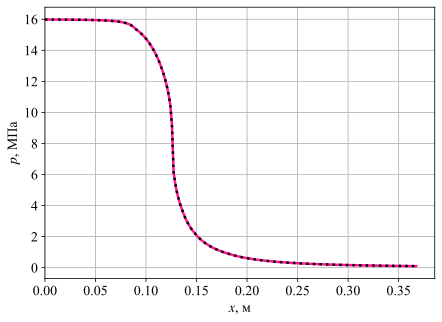

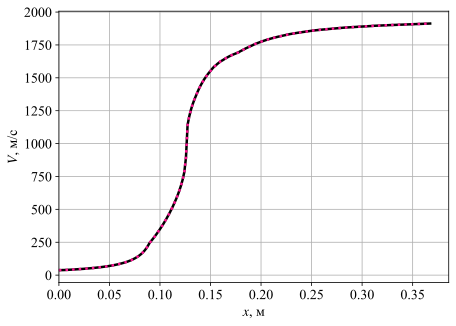

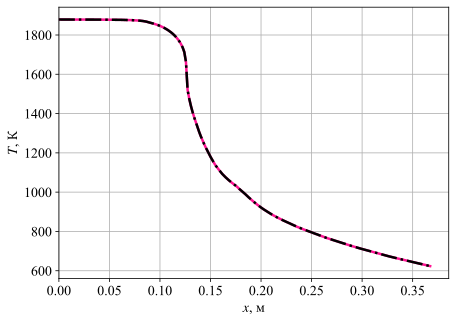

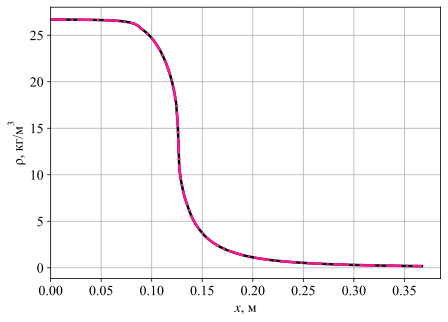

In [4]:
plt.figure(figsize=(7,5))
plt.plot(xs,ps/1e6, c='deeppink', linewidth=2.5)
plt.plot(xs,ps/1e6, c='black', linestyle=':', linewidth=2.5)
plt.ylabel('$\mathit{p}$, МПа')
plt.xlabel('$\mathit{x}$, м')
plt.xlim(left = 0)
plt.grid()
#plt.savefig('px.svg', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,5))
plt.plot(xs,Vs, c ='black', linewidth=2.5)
plt.plot(xs,Vs, c ='deeppink', linestyle=':', linewidth=2.5)
plt.ylabel('$\mathit{V}$, м/с')
plt.xlabel('$\mathit{x}$, м')
plt.xlim(left = 0)
plt.grid()
#plt.savefig('Vx.svg', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,5))
plt.plot(xs,Ts, c = 'deeppink', linewidth=2.5)
plt.plot(xs,Ts, c = 'black', linewidth=2.5, linestyle='-.')
plt.ylabel('$\mathit{T}$, К')
plt.xlabel('$\mathit{x}$, м')
plt.xlim(left = 0)
plt.grid()
#plt.savefig('Tx.svg', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,5))
plt.plot(xs,rhos, c = 'black', linewidth=2.5)
plt.plot(xs,rhos, c = 'deeppink', linewidth=2.5, linestyle='-.')
plt.ylabel('$\\rho$, кг/м$^3$')
plt.xlabel('$\mathit{x}$, м')
plt.xlim(left = 0)
plt.grid()
#plt.savefig('Tx.svg', dpi=300, bbox_inches='tight')
plt.show()

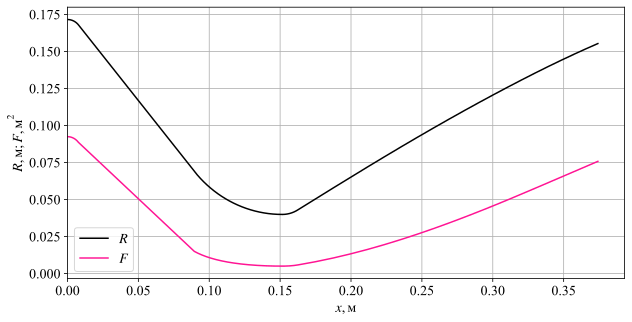

In [27]:
plt.figure(figsize=(10,5))
split = 4
plt.plot(x_soplo[:-split],R_soplo[:-split], label = '$\mathit{R}$', color='black')
plt.plot(x_soplo[:-split],F(x_soplo)[:-split], label = '$\mathit{F}$', color='deeppink')

plt.ylabel('$\mathit{R}, м; \mathit{F}, м^2$')
plt.xlabel('$\mathit{x}, м$')
plt.xlim(left = 0)
plt.legend()
plt.grid()
plt.savefig('D_F.svg', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
G_t = omega / t_r
G_g = G_t * (1 - z)
G_s = G_t * z

rho = lambda x: pf(x) / (R(pf(x),Tf(x)) * Tf(x))

Cx = lambda Re: 21.12 / Re + 6.3 / np.sqrt(Re) + 0.25

G_t, G_g, G_s

(38.54615384615384, 27.714684615384613, 10.831469230769232)

In [7]:
def sys(x, Y, dx, rho_g):
    rho_gi, V_si, T_si, p_gi, T_gi, V_gi, Fi, rho_si = Y

    Cp = cp(p_gi,T_gi)
    mu_g = mu(p_gi,T_gi)
    Rei = abs(V_gi - V_si) * ds * rho_gi / mu_g
    Pr = mu_g * Cp / lambda_t(p_gi,T_gi)
    Nu = 2 + 0.459 * Rei**0.55 * Pr**0.33
    alphai = Nu * lambda_t(p_gi,T_gi) / ds

    drho_g = rho_g - rho_gi

    dV_s = 3 / 4 * Cx(Rei) * rho_gi * (V_gi - V_si) * np.abs(V_gi - V_si) / (ds * V_si * rho_kf) * dx

    dT_s = 6 * alphai * (T_gi - T_si) / (rho_kf * cs * V_si * ds) * dx

    pg1 = z / (1 - z) * V_gi * dV_s - z / (1 - z) * (cs * dT_s + V_si * dV_s)
    pg2 = k(p_gi,T_gi) * p_gi / rho_gi * drho_g
    dp_g = k(p_gi,T_gi) * p_gi / (Cp * T_gi) * pg1 + pg2

    dV_g = -1 / (V_gi * rho_gi) * dp_g - z / (1 - z) * dV_s

    Tg1 = 1 / rho_gi * dp_g + z / (1 - z) * V_gi * dV_s
    Tg2 = z / (1 - z) * (cs * dT_s + V_si * dV_s)
    dT_g = 1 / Cp * (Tg1 - Tg2)

    return np.array([0, dV_s, dT_s, dp_g, dT_g, dV_g, 0, 0])

def euler(Lc, n, kp, rhon):
    xs, dx = np.linspace(0,Lc,n+1,retstep=True)
    
    result = dict()
    keys = ['x','rho_g','V_s','T_s', 'p_g', 'T_g', 'V_g', 'F', 'rho_s']
    Y0 = np.array([kp*rhon(0),0.9998*Vf(0),T0,p0,T0,Vf(0),G_g / (Vf(0) * kp*rhon(0)),G_s / (Vf(0) * F(0))])

    for key, val in zip(keys,np.append(0,Y0)):
        result[key] = np.array([val])

    Yi = Y0
    for x in xs[1:]:
        rho_g = kp*rhon(x)
        Yi = Yi + sys(x,Yi,dx,rho_g)
        Yi[0] = rho_g
        Yi[-2] = G_g / (Yi[-3] * rho_g)
        Yi[-1] = G_s / (Yi[1] * Yi[-2])

        for key, val in zip(keys,np.append(x,Yi)):
            result[key] = np.append(result[key], val)

    return result

def euler_kon(Lc, n):
    kp = np.array([1]*(n+1))
    rhon = rho
    print(abs(kp.mean()))
    while abs(kp.mean() - 1) > 1e-2: # Никогда же не войдём?
        result = euler(Lc,n,kp,rhon)
        kp = F(result['x']) / result['F']
        rhon = interp1d(result['x'],kp*result['rho_g'])

    return result

In [75]:
res = euler(x_soplo[-6], 5000, 0.8, rho)

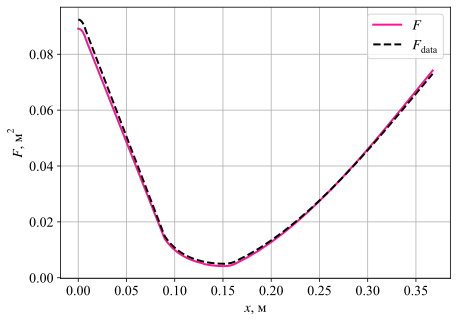

In [93]:
plt.figure(figsize=(7,5))
# plt.plot(res['x'],res['F'],label = '$\mathit{F}$')
split = 80
plt.plot(xs[:split],F(xs[:split])*0.97-0.0005,c = 'deeppink', linewidth=2)
plt.plot(xs[split:],F(xs[split:])*1.03-0.001,c = 'deeppink',label = '$\mathit{F}$', linewidth=2)
plt.plot(xs,F(xs),c = 'black',label = '$\mathit{F}_{data}$',ls = '--', linewidth=2)
plt.grid()
plt.xlabel('$\mathit{x}$, м')
plt.ylabel('$\mathit{F}$, $м^2$')
plt.legend()
plt.savefig('Fres.svg', dpi=300, bbox_inches='tight')
plt.show()

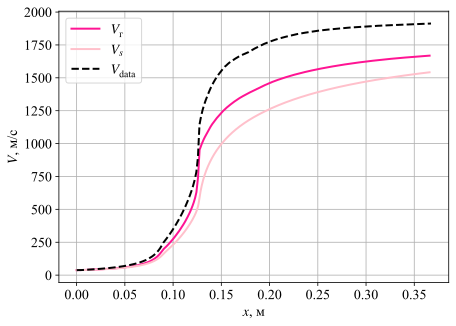

In [95]:
res = euler(x_soplo[-6], 5000, 0.8, rho)
plt.figure(figsize=(7,5))
plt.plot(res['x'],res['V_g'],c = 'deeppink',label = '$\mathit{V}_{г}$', linewidth=2)
plt.plot(res['x'],res['V_s'],c = 'pink',label = '$\mathit{V_{s}}$', linewidth=2)
plt.plot(xs,Vs,c = 'black',ls = '--',label = '$\mathit{V}_{data}$', linewidth=2)
plt.grid()
plt.xlabel('$\mathit{x}$, м')
plt.ylabel('$\mathit{V}$, м/с')
plt.legend()
plt.savefig('Vres.svg', dpi=300, bbox_inches='tight')
plt.show()

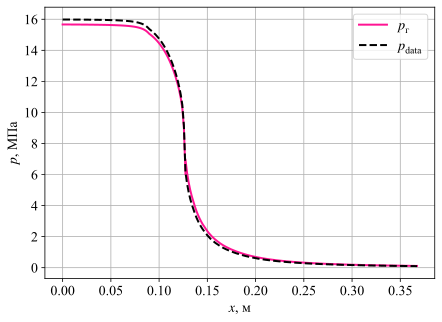

In [96]:
plt.figure(figsize=(7,5))
# plt.plot(res['x'],res['p_g']/1e6,label = '$\mathit{p}_{г}$')
split = 78
plt.plot(xs[:split + 1],ps[:split + 1]/1e6*0.98,c = 'deeppink',label = '$\mathit{p}_{г}$', linewidth=2)
plt.plot(xs[split:],ps[split:]*1.13/1e6,c = 'deeppink', linewidth=2)
plt.plot(xs,ps/1e6,c = 'black',ls = '--',label = '$\mathit{p}_{data}$', linewidth=2)

plt.grid()
plt.xlabel('$\mathit{x}$, м')
plt.ylabel('$\mathit{p}$, МПа')
plt.legend()
plt.savefig('pres.svg', dpi=300, bbox_inches='tight')
plt.show()

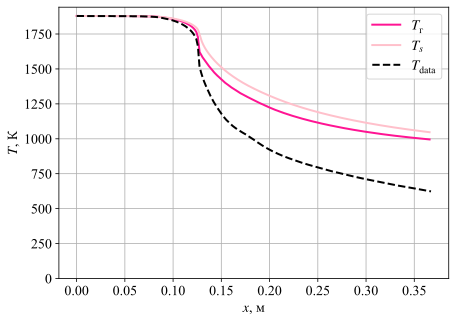

In [98]:
plt.figure(figsize=(7,5))
plt.plot(res['x'],res['T_g'],c = 'deeppink',label = '$\mathit{T}_{г}$', linewidth=2)
plt.plot(res['x'],res['T_s'],c = 'pink',label = '$\mathit{T_{s}}$', linewidth=2)
plt.plot(xs,Ts,c = 'black',ls = '--',label = '$\mathit{T}_{data}$', linewidth=2)
plt.ylim(0)
plt.grid()
plt.xlabel('$\mathit{x}$, м')
plt.ylabel('$\mathit{T}$, К')
plt.legend()
plt.savefig('Tres.svg', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
K_V = res['V_s'][-1] / res['V_g'][-1]
K_T = res['T_s'][-1] / res['T_g'][-1]
K_V, K_T

(0.8640328411030095, 2.896716492179637)

In [14]:
print(res['V_s'][-1], res['V_g'][-1])
print(res['T_s'][-1], res['T_g'][-1])

1928.5475956933333 2232.0304321203607
519.7366477775446 179.42268398743718
